In [1]:
from src import UDP_RX, SlidingBook, MACChecker
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import json
import socket
import struct
import pickle





# Getting the Parameters from the sender and Calculating the offset
def receive_param(IP, PORT):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind((IP, PORT))
        s.listen()
        conn, addr = s.accept()
        with conn:

            param = b''
            while True:
                data = conn.recv(1024)
                if not data or data == b'END':
                    break
                param += data
            # print(param)
            data2 = conn.recv(16)
            # print(data2)
            offset = time.time() - struct.unpack('d', data2)[0]
            
        param = json.loads(param.decode('utf-8'))
        param['OFFSET'] = offset 
        return param


def run_experiment(IP, PORT, param):
    total_avg_verification = []
    goodput_total = []
    total_latency = []
    framecnt_total = []

    cnt = 0
    framecnt = 0
    start_frame_cnt = time.time()
    start = time.time()

    while True:

        buffer =  SlidingBook(num_pages=100, page_size=len(param['X']))
        page_processor = MACChecker(X = param['X'], Y = param['Y'], secret_key=param['KEY'].encode(), digestmod=param['DIGESTMOD'])
        udp_rx = UDP_RX(IP= IP, PORT= PORT, buffer=buffer, page_processor= page_processor, Payload_Size_Byte=param['PAYLOAD_SIZE_BYTE'])

        msg, verification_count, latency, goodput = udp_rx.receive()
        total_avg_verification.append(np.average(verification_count))
        total_latency.append(np.average(latency))
        goodput_total.append(goodput)


        if msg is not None and len(msg) > 0:  # Ensure rec is not None and has valid data
            nparr = np.frombuffer(msg, np.uint8)
            
            if nparr is not None and len(nparr) > 0:  # Check if nparr is valid
                try:
                    frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
                    
                    if frame is not None:  # Ensure that the frame is successfully decoded
                        cv2.imshow('Received Video', frame)
                        framecnt += 1
                        if time.time() - start_frame_cnt > 1:
                            framecnt_total.append(framecnt)
                            start_frame_cnt = time.time()
                            print(f"{framecnt} fps")
                            framecnt = 0
                            
                        if cv2.waitKey(1) & 0xFF == ord('q'):
                            break
                    else:
                        # print("Failed to decode frame.")
                        pass
                except Exception as e:
                    # print(f"Error decoding frame: {e}")
                    pass
            else:
                # print("Empty or invalid buffer received.")
                pass
        else:
            # print("Received an empty or invalid page.")
            pass

        if cnt % 100 == 0:
            print(f"avg_verification: {np.average(total_avg_verification)}, latency: {np.average(total_latency)}")
        cnt += 1
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        if time.time() - start > param['DURATION']:
            break

    cv2.destroyAllWindows()

    ## saving the parameters and the results as a json file

    results = {
        "avg_verification": total_avg_verification,
        "latency": total_latency,
        "goodput": goodput_total,
        "frame_rate": framecnt_total,
        "param": param
    }   

    # read a pickle file to get the previous results

    try:
        with open("results.pkl", 'rb') as f:
            file = pickle.load(f)
            experiment_nr = len(file)
            file[experiment_nr]=results
            with open("results.pkl", 'wb') as f:
                pickle.dump(file, f)
    except:
        # create a new file
        print("Creating a new file")
        file = {0:results}
        with open("results.pkl", 'wb') as f:
            pickle.dump(file, f)


#### parameters that needs to be exhanged between the sender and the receiver #####
IP = "0.0.0.0"
PORT = 23422
#################################################################################### 
## test the receiver
param = receive_param(IP=IP, PORT=PORT)
run_experiment(IP=IP, PORT=PORT, param=param)

2024-09-04 13:01:23.091 Python[1611:17658] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.
/Users/mohammadkashani/Library/Python/3.9/lib/python/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/mohammadkashani/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


avg_verification: 1.0, latency: -0.05945810794830322
10 fps
17 fps
17 fps
19 fps
avg_verification: nan, latency: nan
17 fps
19 fps
18 fps
18 fps
17 fps
avg_verification: nan, latency: nan
Creating a new file


In [2]:
#### parameters that needs to be exhanged between the sender and the receiver #####
IP = "0.0.0.0"
PORT = 23422
#################################################################################### 
while True:
    param = receive_param(IP=IP, PORT=PORT)
    run_experiment(IP=IP, PORT=PORT, param=param)
    time.sleep(.1)

avg_verification: 10.0, latency: -0.053886698274051445
11 fps
16 fps
17 fps
15 fps
avg_verification: nan, latency: nan
16 fps
17 fps
16 fps
avg_verification: nan, latency: nan
18 fps
16 fps
16 fps
14 fps
avg_verification: nan, latency: nan
17 fps
13 fps
16 fps
17 fps
avg_verification: nan, latency: nan
16 fps
17 fps
15 fps
15 fps
avg_verification: nan, latency: nan
16 fps
19 fps
18 fps
avg_verification: nan, latency: nan
16 fps
18 fps
16 fps
17 fps
avg_verification: nan, latency: nan
16 fps
17 fps
avg_verification: 10.0, latency: -0.020389767487843834
9 fps
16 fps
16 fps
17 fps
avg_verification: nan, latency: nan
16 fps
15 fps
18 fps
15 fps
avg_verification: nan, latency: nan
16 fps
18 fps
15 fps
13 fps
avg_verification: nan, latency: nan
15 fps
16 fps
14 fps
15 fps
avg_verification: nan, latency: nan
17 fps
15 fps
14 fps
17 fps
avg_verification: nan, latency: nan
17 fps
14 fps
14 fps
16 fps
avg_verification: nan, latency: nan
15 fps
15 fps
18 fps
16 fps
avg_verification: nan, latency:

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


avg_verification: 7.133333333333334, latency: -0.19542668597275287


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 2629 extraneous bytes before marker 0xc4
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


7 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 344 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


10 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


13 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


avg_verification: nan, latency: nan


Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


12 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1741 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code


13 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 6 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 6 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


10 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


11 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


avg_verification: nan, latency: nan


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 6 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 293 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


13 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


11 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


12 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


avg_verification: nan, latency: nan
9 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 438 extraneous bytes before marker 0xc4
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 1992 extraneous bytes before marker 0xc4
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


10 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2


9 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 11 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 3165 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


9 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


avg_verification: nan, latency: nan


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


9 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 2348 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


11 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


10 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


avg_verification: nan, latency: nan


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


9 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment


16 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 2591 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


13 fps
avg_verification: nan, latency: nan


Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


12 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


11 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


8 fps


Corrupt JPEG data: 2334 extraneous bytes before marker 0xc4
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


avg_verification: nan, latency: nan


Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


14 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


11 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


8 fps


Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


avg_verification: nan, latency: nan


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


avg_verification: 6.40625, latency: -0.1582665964002498


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


6 fps


Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 2367 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


10 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 2425 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


8 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code


avg_verification: nan, latency: nan
9 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JP

10 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


9 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 11 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code


12 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


avg_verification: nan, latency: nan


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


10 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


9 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 986 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


15 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2912 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


avg_verification: nan, latency: nan


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


13 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


14 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment


7 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2726 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


10 fps
avg_verification: nan, latency: nan


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 2386 extraneous bytes before marker 0xc4
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2559 extraneous bytes before marker 0xda
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG da

9 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


7 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code


12 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


avg_verification: nan, latency: nan


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


11 fps


Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 296 extraneous bytes before marker 0xda
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 11 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt

10 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


10 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


avg_verification: nan, latency: nan


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


11 fps


Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code


15 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


11 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment


11 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


avg_verification: nan, latency: nan


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


12 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 2250 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


14 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


12 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


avg_verification: nan, latency: nan


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


10 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


avg_verification: 3.8529411764705883, latency: nan


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


5 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: pre

7 fps


Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7163 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment


6 fps
avg_verification: nan, latency: nan


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2138 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG dat

10 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1829 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda


3 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code


avg_verification: nan, latency: nan


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 12 extraneous bytes before marker 0xda


6 fps


Corrupt JPEG data: 1657 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


6 fps


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 2273 extraneous bytes before marker 0xac
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 2034 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


10 fps


Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: 11 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code


7 fps
avg_verification: nan, latency: nan


Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


4 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 11 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


3 fps


Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code


5 fps
avg_verification: nan, latency: nan


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 2461 extraneous bytes before marker 0xc4
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: ba

7 fps


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 2600 extraneous bytes before marker 0xc4
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code


5 fps


Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code


5 fps
avg_verification: nan, latency: nan


Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 5 extraneous bytes before marker 0xc2
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 7 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: bad Huffman code
Corrupt JPEG data: 12 extraneous bytes before marker 0xda
Corrupt JPEG data: bad Huffman code


7 fps


Experiment 0


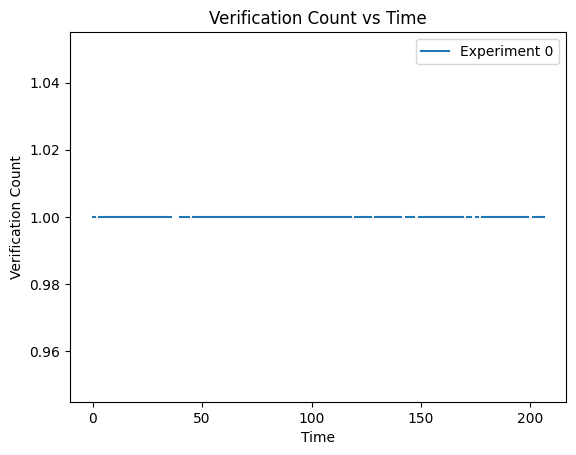

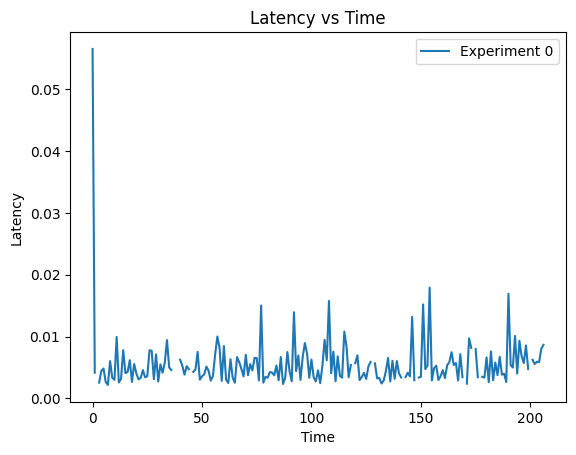

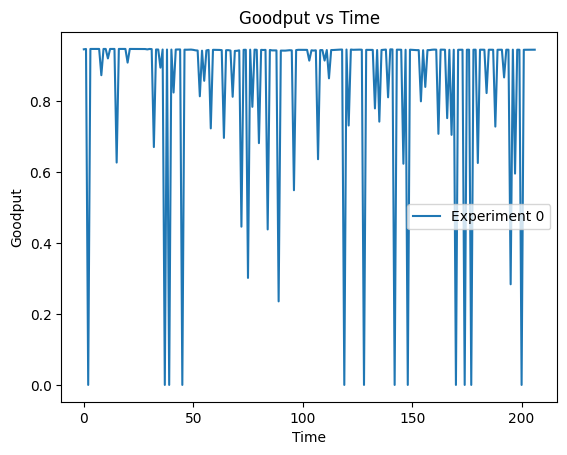

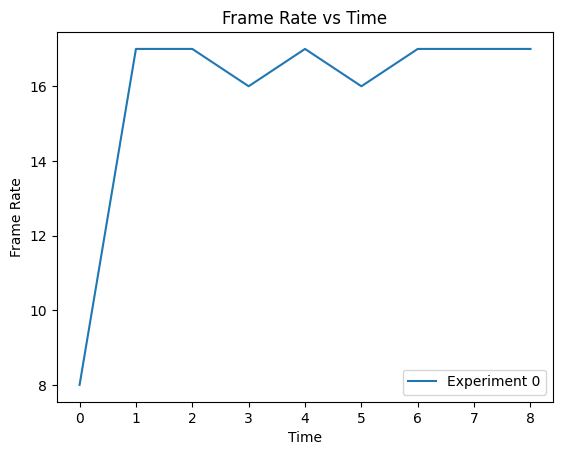

{'X': [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]], 'Y': [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]

In [ ]:
# opening the pickle file and plotting the results
with open("results.pkl", 'rb') as f:
    results = pickle.load(f)
    for i in range(max(len(results)- 10,0), len(results)):
        print(f"Experiment {i}")
        plt.plot(results[i]['avg_verification'], label=f"Experiment {i}")
        plt.xlabel('Time')
        plt.ylabel('Verification Count')
        plt.title('Verification Count vs Time')
        plt.legend()
        plt.show()

        plt.plot(np.array(results[i]['latency']) - results[i]['param']["OFFSET"], label=f"Experiment {i}")
        plt.xlabel('Time')
        plt.ylabel('Latency')
        plt.title('Latency vs Time')
        plt.legend()
        plt.show()

        plt.plot(results[i]['goodput'], label=f"Experiment {i}")
        plt.xlabel('Time')
        plt.ylabel('Goodput')
        plt.title('Goodput vs Time')
        plt.legend()
        plt.show()

        plt.plot(results[i]['frame_rate'], label=f"Experiment {i}")
        plt.xlabel('Time')
        plt.ylabel('Frame Rate')
        plt.title('Frame Rate vs Time')
        plt.legend()
        plt.show()
    print(results[0]['param'])